----
# Bayesian Data Analysis - Premier League Project
----

## Table of Contents
<ul>
    <li>Imports</li>
    <li>Background</li>
    <li>Data</li>
    <li>Model 1: Pooled model using ManU forwards</li>
    <li>Model 2: Separate model using ManU forwards as a prior</li>
    <li>Model 3: Hierarchical model using new PL forwards</li>
    <li>Model comparison</li>
</ul>

## Imports

In [53]:
import numpy as np
import arviz as az
import stan
import nest_asyncio
import matplotlib.pyplot as plt
from scipy import stats

## Background

As I am a big football fan, I have decided to do the project about the English Premier League. In the summer of 2021 a relatively big English football club, Manchester United (ManU), decided to re-sign Ronaldo from Juventus. This move makes it possible to do some interesting predictions of how well Ronaldo will perform in the English Premier League (EPL).

<b>This project</b><br>
Despite of being a Tottenham Hotspur fan, in this project we are going to predict how many goals Ronaldo will score for Manchester United in season 2021-2022. As Ronaldo has not played in the EPL for ages and Serie A/LaLiga goals are arguably not comparable with EPL goals, we cannot use for example the average of Ronaldo's previous goal scoring numbers as a point estimate for the goals in EPL. Therefore, we are going to model Ronaldo's expected goal scoring amount using Bayesian methods with one pooled model, one separate model and one hierarchical model. All the models use data also from the EPL. The models are explained comprehensively in the Model-part of this notebook.

<b>IMPORTANT</b><br>
This project is just for training with Bayesian Data Analysis and the model provided in the project is not intended to work in the real world.

## Data

In this project we are going to use three different datasets which can be found in the following files:<br>
<ul>
    <li>cr7.txt</li>
    <li>manu.txt</li>
    <li>epl.txt</li>
</ul>

As Ronaldo has played 12 seasons (from season 2009-2010 until 2020-2021) outside the EPL, it is not possible to obtain a huge amount of data of the goals scored. But the beauty of Bayesian methods is that we can work with small amount of data and still get a distribution of our predictions.<br>

<b>All models</b><br>
For all of our models we are going to use data of Ronaldo's goal scoring in LaLiga and Serie A (file cr7.txt). For simplicity in all of our models we are ignoring goals scored in other competitions such as Champions League. Ronaldo's goal scoring data is gathered from ESPN.com and it is manually collected as there is no universal free database for football statistics.

<b>Pooled model: Prediction using ManU forward data</b><br>
The data for this model can be found in manu.txt and cr7.txt. The ManU data contains top 3 goal scorers (forwards and attacking midfielders) from Mancher United from 12 seasons. Each row represents a season and each column in the data the top goal scorer such that first column is the top goal scorer, the second column the second and the third column the third. In this pooled model, this separation does not however affect in any way as the goal amounts are being pooled into one dimensional dataset. The ManU goals are from Premier League's official website, premierleague.com, and they are also manually collected. We will use data starting from season 2009-2010 until season 2020-2021, as these are the seasons Ronaldo played in LaLiga and Serie A. 



<b>Basic model: Prediction using ManU forwards as a prior</b><br>
This model uses the same data as the pooled model but this time the ManU data is only used as a prior for the model and the prediction happens by using only cr7.txt as the data, making the model a separate model.
 
<b>Hierarchical model: Prediction using PL forward data</b><br>
In this third model the data from epl.txt and cr7.txt is used. More coming soon...


In [23]:
# DATA FOR RONALDO
data = []
with open("./data/cr7.txt") as file:
    for line in file:
        values = line.rstrip()
        data.append(values)
data_cr7 = np.array([int(value) for value in data])

In [24]:
# DATA FOR MANU FORWARDS
data = []
with open("./data/manu.txt") as file:
    for line in file:
        values = line.rstrip().split(",")
        data.append(values)
data_manu = np.array([[int(value) for value in values] for values in data])

In [25]:
# DATA FOR OTHER PREMIER LEAGUE FORWARDS
data = []
with open("./data/epl.txt") as file:
    for line in file:
        values = line.rstrip()
        data.append(values)
data_epl = np.array([int(value) for value in data])

We can also plot the data before we start to predict, so that we have some idea on what we are talking about.

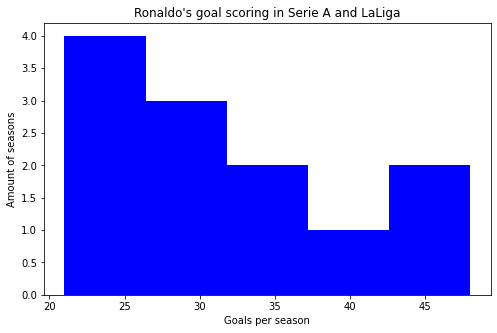

In [26]:
plt.figure(figsize=(8, 5))
plt.hist(x=data_cr7, bins=5, color="blue")
plt.title("Ronaldo's goal scoring in Serie A and LaLiga")
plt.xlabel("Goals per season")
plt.ylabel("Amount of seasons");

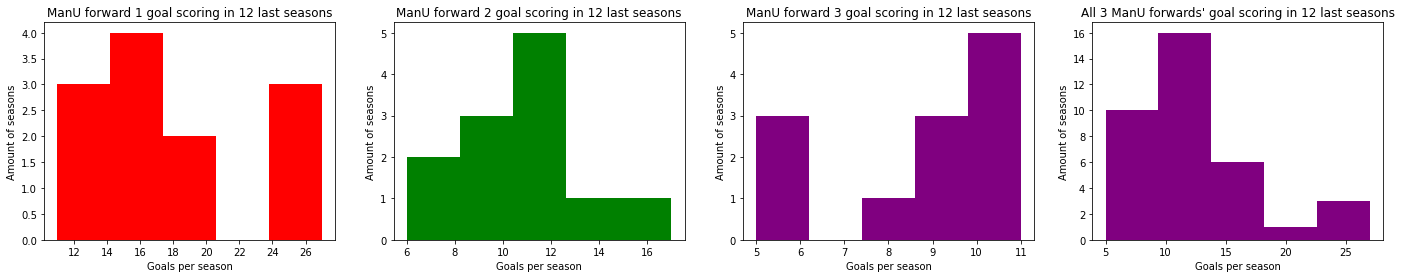

In [27]:
fig, ax = plt.subplots(1,4)
fig.set_size_inches(24, 4)

ax[0].hist(x=data_manu[:, 0], bins=5, color="red")
ax[0].set_title("ManU forward 1 goal scoring in 12 last seasons")
ax[0].set_xlabel("Goals per season")
ax[0].set_ylabel("Amount of seasons")

ax[1].hist(x=data_manu[:, 1], bins=5, color="green")
ax[1].set_title("ManU forward 2 goal scoring in 12 last seasons")
ax[1].set_xlabel("Goals per season")
ax[1].set_ylabel("Amount of seasons")

ax[2].hist(x=data_manu[:, 2], bins=5, color="purple")
ax[2].set_title("ManU forward 3 goal scoring in 12 last seasons")
ax[2].set_xlabel("Goals per season")
ax[2].set_ylabel("Amount of seasons");

ax[3].hist(x=data_manu.flatten(), bins=5, color="purple")
ax[3].set_title("All 3 ManU forwards' goal scoring in 12 last seasons")
ax[3].set_xlabel("Goals per season")
ax[3].set_ylabel("Amount of seasons");

## Model 1 - Pooled Model Using ManU Forwards

### Description

In the first model we are going to model Ronaldo's expected goal amount in a season using a pooled model. As data we have the goal amounts of ManU forwards from previous seasons as well as Ronaldo's goal amounts as explained in the Data section. With the data we can form a pooled model of the ManU data and predict what would a new ManU player (Ronaldo) score in a season. By using the historical data from other ManU forwards we add the "ManU style of play" into the model as it is likely that each team in EPL has its own style of play and therefore also own amount of goals scored. 

<b>Model</b><br>
As goals can be thought to have random arrivals during the season, we could make a common assumption that the arrivals of goals are independent and they follow an exponential distribution. Therefore, the amount of these arrivals follows a poisson distribution. Therefore, we can approximate the amount of goals in a season as a counting process which follows a Poisson distribution (number of goals in a season). Therefore, we can use as our likelihood the following:

$$
y \sim Poisson(\lambda)
$$

As prior we know that the mean must be positive, therefore also the lambda which is same as the mean in Poisson distributions. We also know that the Gamma distribution belongs to the conjugate family of Poisson distribution and is always positive. Therefore we could use as prior for the parameter lambda a gamma distribution, which is also often used as the prior for a Poisson distribution. Better be safe than sorry in our model:

$$
\lambda \sim gamma(\alpha, \beta)
$$

Now, what should we use as the values for our parameters. In a Gamma distribution alpha is the shape parameter and beta is the inverse of scale parameter. The mean of the Gamma distribution is alpha divided by beta. For our first prior we could forget the all this theory and use a weakly informative prior such as:
$$
\lambda \sim gamma(0.001, 0.001)
$$
which has a long tail and accepts any data as typical for it. This is also plotted below.

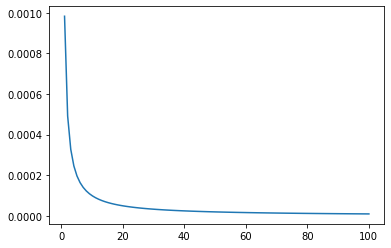

In [28]:
alpha = 0.001
beta = 0.001
x = np.linspace(0, 100, 100)
y = stats.gamma.pdf(x, a=alpha, scale=1/beta)
plt.plot(x, y);

However, as we have some knowledge of Ronaldo's past performance, let's not use only a boring weakly informative prior. Let's try an informative one. To add prior knowledge of Ronaldo's goals, we can try to change the alpha and beta in our prior to fit the goals scored by Ronaldo. To fit the prior distribution with our previous data we could for example modify alpha and beta so that the data is inside the 90% percentile interval of the Gamma distribution. However, this would be quite hard for the Gamma distribution. Therefore, an alternative approach is selected. Let's first find out the smallest amount of goals Ronaldo scored and the largest, as well as the mean and the standard deviation.

In [29]:
s = data_cr7.min()
l = data_cr7.max()
m = data_cr7.mean()
std = data_cr7.std()
print(f"Smallest: {s}\nLargest: {l}\nMean: {m:.2f}\nStandard deviation: {std:.2f}");

Smallest: 21
Largest: 48
Mean: 32.67
Standard deviation: 8.05


Now we want values between 21 and 48 be within the highest probability density. We want also the mean to be around the real mean of the data and therefore alpha divided by beta should be approximately 33. We could  use the Method of Moments to get our estimates for alpha and beta obtaining the following values:
$$
\alpha = \frac{E[X]^{2}}{Var[X]} = 16.5
$$
$$
\beta = \frac{E[X]}{Var[X]} = 0.5
$$
With these values alpha divided by beta is 33. Let's try to plot these values to see if they look reasonable.

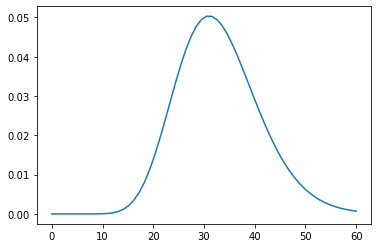

In [9]:
alpha = 16.5
beta = 0.5
x = np.linspace(0, 60, 60)
y = stats.gamma.pdf(x, a=alpha, scale=1/beta)
plt.plot(x, y);

With alpha = 16.5 and beta = 0.5 the distribution looks like it would represent Ronaldo's previous goals. Let's use these parameters in our informative prior distribution.
$$
\lambda \sim gamma(16.5, 0.5)
$$

### Stan model

As the resulting posterior distribution is hard to compute, we are going to sample from it using Markov Chain Monte Carlo methods. To do this, we use a software called Stan and its Python library PyStan3. Stan uses dynamic Hamiltonian Monte Carlo (by default No-U-Turn Sampler, NUTS) as the MCMC-method to sample from the posterior distribution as it needs fewer Markov Chain samples to converge than for example Gibbs sampling.

In [54]:
# STAN CODE
stan_list = []
with open("./models/nonhierarch.stan") as file:
    for line in file:
        stan_list.append(line)
stan_code = "".join(stan_list)
print(stan_code)

data {
    int<lower=0> N; // NUMBER OF SEASONS
    int y[N]; // HISTORICAL DATA
    real<lower=0> alpha; // PARAMETER FOR GAMMA DISTRIBUTION
    real<lower=0> beta; // PARAMETER FOR GAMMA DISTRIBUTION
}
parameters {
    real<lower=0> la; // LAMBDA FOR POISSON
}
model {
    target += gamma_lpdf(la | alpha, beta); // PRIOR
    target += poisson_lpmf(y | la); // LIKELIHOOD
}
generated quantities {
    real pred = poisson_rng(la); // PREDICTION FOR CR7

    vector[N] log_lik;
      for (i in 1:N)
        log_lik[i] = poisson_lpmf(y[i] | la);
}


### Implementation

In the models we are going to use 3 different chains with 4000 samples and 4000 warm-up samples, as warm-up of one half of the total samples is a conservative approach that should guarantee that the chains have converged. 

First the model with weakly informative prior:

In [31]:
# STAN MODEL
nest_asyncio.apply()
inputs = {'N': data_manu.shape[0]*data_manu.shape[1], 'y': data_manu.flatten(), 'alpha': 0.001, 'beta': 0.001}
model = stan.build(program_code=stan_code, data=inputs);
weakly_pooled_fit = model.sample(num_chains=3, num_samples=4000, num_warmup=4000, save_warmup=False);
weakly_pooled_df = weakly_pooled_fit.to_frame()

Building...



Building: found in cache, done.Messages from stanc:
Sampling:   0%
Sampling:  33% (8000/24000)
Sampling:  67% (16000/24000)
Sampling: 100% (24000/24000)
Sampling: 100% (24000/24000), done.
Messages received during sampling:
  Gradient evaluation took 5e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.05 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.04 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 5e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.05 seconds.
  Adjust your expectations accordingly!


Then the model with informative prior:

In [32]:
# STAN MODEL
nest_asyncio.apply()
inputs = {'N': data_manu.shape[0]*data_manu.shape[1], 'y': data_manu.flatten(), 'alpha': 16.5, 'beta': 0.5}
model = stan.build(program_code=stan_code, data=inputs);
informative_pooled_fit = model.sample(num_chains=3, num_samples=4000, num_warmup=4000, save_warmup=False);
informative_pooled_df = informative_pooled_fit.to_frame()

Building...



Building: found in cache, done.Messages from stanc:
Sampling:   0%
Sampling:  33% (8000/24000)
Sampling:  67% (16000/24000)
Sampling: 100% (24000/24000)
Sampling: 100% (24000/24000), done.
Messages received during sampling:
  Gradient evaluation took 5e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.05 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.04 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.04 seconds.
  Adjust your expectations accordingly!


### Convergence diagnostics

Now that we have built the models and obtained the samples we should check that our chains have converged. To check the convergency we will first use visual inspection, in other words we will plot the chains (lambda values) and see if they mix together.

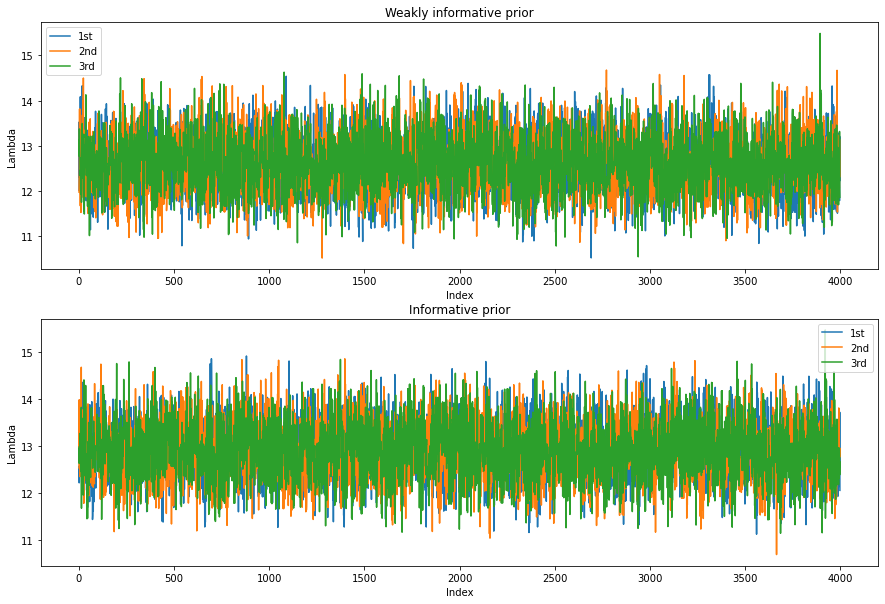

In [13]:
fig, ax = plt.subplots(2, 1)
fig.set_size_inches(15, 10)

ax[0].plot(range(4000), weakly_pooled_fit["la"][0][0:4000], label="1st")
ax[0].plot(range(4000), weakly_pooled_fit["la"][0][4000:8000], label="2nd")
ax[0].plot(range(4000), weakly_pooled_fit["la"][0][8000:12000], label="3rd")
ax[0].legend()
ax[0].set_title("Weakly informative prior")
ax[0].set_xlabel("Index")
ax[0].set_ylabel("Lambda")

ax[1].plot(range(4000), informative_pooled_fit["la"][0][0:4000], label="1st")
ax[1].plot(range(4000), informative_pooled_fit["la"][0][4000:8000], label="2nd")
ax[1].plot(range(4000), informative_pooled_fit["la"][0][8000:12000], label="3rd")
ax[1].legend()
ax[1].set_title("Informative prior")
ax[1].set_xlabel("Index")
ax[1].set_ylabel("Lambda");

The chains seem to mix well together both in the weakly informative prior model and also in the informative prior model. We could also check the convergency with R_hat-value, which compares the within-chain variance with the between-chain variance. If the chains have converged the R_hat will be close to 1 or in other words less than 1.01 as the within-chain variance should be equal to the between-chain variance (they should not differ).

In [14]:
weakly_chains = np.array((weakly_pooled_fit["la"][0][0:4000], 
                    weakly_pooled_fit["la"][0][4000:8000], weakly_pooled_fit["la"][0][8000:12000]))
informative_chains = np.array((informative_pooled_fit["la"][0][0:4000], 
                    informative_pooled_fit["la"][0][4000:8000], informative_pooled_fit["la"][0][8000:12000]))
print(f"Weakly informative chains' R_hat: {az.rhat(weakly_chains)}\nInformative chains' R_hat: {az.rhat(informative_chains)}")

Weakly informative chains' R_hat: 1.0001221039426396
Informative chains' R_hat: 1.0005175250100204


From the R_hat values we can see that the chains have in both models clearly converged.

### Posterior predictive checking

Now that we know that our chains have converged in both models, we would like to assess the predictive performance of the models. To assess this, we use Pareto-smoothed importance sampling leave-one-out cross validation (PSIS-LOO-CV).

First for the weakly informative prior.

In [15]:
az.loo(weakly_pooled_fit, pointwise=True)

Computed from 12000 by 36 log-likelihood matrix

         Estimate       SE
elpd_loo  -118.91    10.30
p_loo        2.46        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       36  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

From the summary we can see that all the k_hat values are under 0.5 which means that the estimate converges quickly. The estimates seem to be reliable. We can also plot these k_hat values.

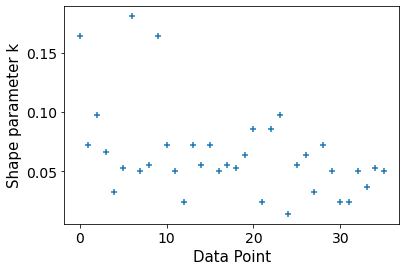

In [33]:
khats = az.loo(weakly_pooled_fit, pointwise=True)
az.plot_khat(khats);

The k_hat values are well below 0.5. This means that the variance of the raw importance ratios is finite, the central limit theorem holds and the estimate converges quickly. Therefore we can consider the PSIS-LOO estimate reliable. From the summary we can also see that the Expected Log Predictive Density From Loo Cross Validation (elpd-loo-cv) value of the model is -118.91 and the effective number of parameters 2.46.

Next we can check these for the informative prior pooled model.

In [18]:
az.loo(informative_pooled_fit, pointwise=True)

Computed from 12000 by 36 log-likelihood matrix

         Estimate       SE
elpd_loo  -118.92     9.83
p_loo        2.31        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       36  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

All the k_hat values are again below 0.5. Then we can plot these values.

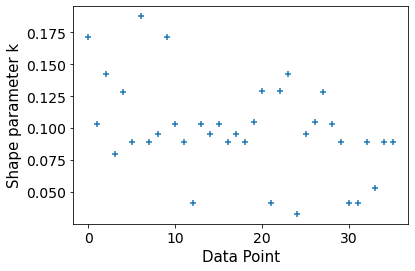

In [34]:
khats = az.loo(informative_pooled_fit, pointwise=True)
az.plot_khat(khats);

The k_hat values are extremely small and therefore the estimates converges quickly. We can consider the PSIS-LOO estimate reliable. From the summary we can see that the Expected Log Predictive Density From Loo Cross Validation (elpd-loo-cv) value for this model is -118.92 and the effective number of parameters 2.31.

### Results

After checking the predictive performance of the models, we would like to know what the models are predicting for Ronaldo's goal amount. To check this we could first plot the histograms of the predicted goal amounts.

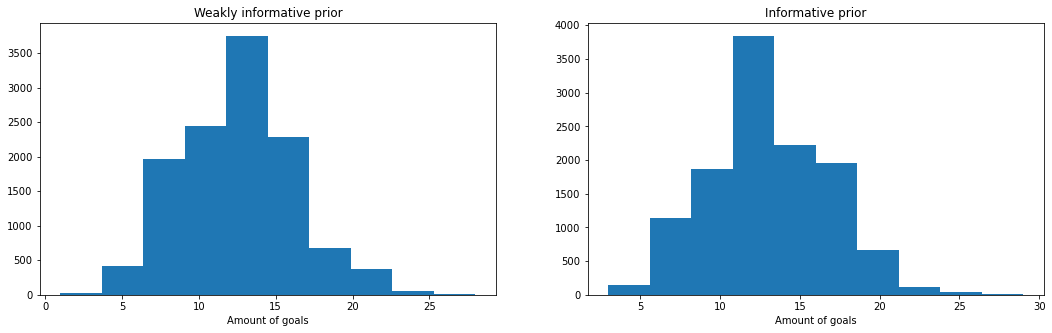

In [20]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(18, 5)

ax[0].hist(weakly_pooled_fit["pred"][0])
ax[0].set_title("Weakly informative prior")
ax[0].set_xlabel("Amount of goals")
ax[1].hist(informative_pooled_fit["pred"][0])
ax[1].set_title("Informative prior")
ax[1].set_xlabel("Amount of goals");

From the histograms we can see that the informative prior doesn't seem to affect the prediction that much. This means that our data in the model plays much bigger role in the predictions. Let's then get the expected goal amount from both models and the 90% credible interval. Before we calculate these values we should get the Monte Carlo Standard Error so that we know how many decimals to report (we should only report digits for which MCSE is 0).

In [21]:
weakly_mcse = az.mcse(np.array((weakly_pooled_fit["la"][0][0:4000], 
                    weakly_pooled_fit["la"][0][4000:8000], weakly_pooled_fit["la"][0][8000:12000])))
informative_mcse = az.mcse(np.array((informative_pooled_fit["la"][0][0:4000], 
                    informative_pooled_fit["la"][0][4000:8000], informative_pooled_fit["la"][0][8000:12000])))
print(f"For the weakly informative prior model (mean): {weakly_mcse[0]}")
print(f"For the informative prior model (mean): {informative_mcse[0]}")

For the weakly informative prior model (mean): 0.007901151308243056
For the informative prior model (mean): 0.00781338300507358


In [22]:
weakly_mcse_q = az.mcse(np.array((weakly_pooled_fit["la"][0][0:4000], 
                    weakly_pooled_fit["la"][0][4000:8000], weakly_pooled_fit["la"][0][8000:12000])), method="quantile", prob=0.9)
informative_mcse_q = az.mcse(np.array((informative_pooled_fit["la"][0][0:4000], 
                    informative_pooled_fit["la"][0][4000:8000], informative_pooled_fit["la"][0][8000:12000])), method="quantile", prob=0.9)
print(f"For the weakly informative prior model (quantile): {weakly_mcse_q}")
print(f"For the informative prior model (quantile): {informative_mcse_q}")

For the weakly informative prior model (quantile): 0.012511379855834726
For the informative prior model (quantile): 0.01106685259545781


First for the model that uses weakly informative prior.

In [23]:
m1 = weakly_pooled_fit["pred"][0].mean()
ci = (np.percentile(weakly_pooled_fit["pred"][0], 5), np.percentile(weakly_pooled_fit["pred"][0], 95))
print(f"Expectation for the mean: {m1:.2f}")
print(f"90 % Credible interval: ({ci[0]:.1f}, {ci[1]:.1f})")

Expectation for the mean: 12.56
90 % Credible interval: (7.0, 19.0)


Then for the model that uses informative prior.

In [24]:
m2 = informative_pooled_fit["pred"][0].mean()
cj = (np.percentile(informative_pooled_fit["pred"][0], 5), np.percentile(informative_pooled_fit["pred"][0], 95))
print(f"Expectation for the mean: {m2:.2f}")
print(f"90 % Credible interval: ({cj[0]:.1f}, {ci[1]:.1f})")

Expectation for the mean: 12.92
90 % Credible interval: (7.0, 19.0)


From the results we can see that there is no big difference between the expectations of the predictions from the two models as the model that uses weakly informative prior predicts 12.56 goals for Ronaldo next season and the model that uses an informative prior predicts 12.92 goals. Both models have also same credible intervals. Therefore, we could deduce that the model is not very sensitive to the selected prior. Both the models have the same Expected Log Predictive Density -values, but as the k_hats of the informative prior model are much lower, the estimates for that model are more reliable. In addition, the informative model uses information of Ronaldo's past performance. Therefore, we are going to select informative prior model's result as our prediction from the pooled model.

<b>Pooled model prediction: 12.92</b>

### Problems in the model

There are some problems in our model even though it is relatively simple. For example, we are assuming that the goals scored by a player in a season follow a Poisson distribution. The model also uses data from Ronaldo's past seasons only as a prior, which makes the predictions more dependent on the Manchester United data. This can be a justified decision but one should take this fact into account.

## Model 2 - Basic Model Using ManU Forwards as a Prior

### Description

In this second model we are going to predict Ronaldo's goals in season 2021-2022 by using a "basic" model. This model uses the same datasets as the previous pooled model but this time the ManU data is only used as a prior in the model. The real data of the model is Ronaldo's previous goal amounts. Basically we are predicting how many goals Ronaldo would score given our prior information of ManU forwards' goals. This type of model would put more emphasis on Ronaldo's skills and less emphasis on the style of football ManU plays and the amount of goals scored in Premier League.

<b>Model</b><br>
As our likelihood we will use again the Poisson distribution and as our prior the Gamma distribution explained in the previous pooled model section. Again we will use one model with a weakly informative prior and one model with an informative pior. In summary, for likelihood we will have the following distribution.
$$
y \sim Poisson(\lambda)
$$
For weakly informative prior we will have the Gamma distribution where alpha=0.001 and beta=0.001 (long tail, mean of 1).
$$
\lambda \sim gamma(0.001, 0.001)
$$
For the informative prior we would like to have the Gamma distribution to represent the ManU forward data. Therefore, we have to fit the values of alpha and beta to the data. To do this, we will use again the Method of Moments presented previously in the pooled model part.

In [35]:
s = data_manu.min()
l = data_manu.max()
m = data_manu.mean()
std = data_manu.std()
print(f"Smallest: {s}\nLargest: {l}\nMean: {m:.2f}\nStandard deviation: {std:.2f}");

Smallest: 5
Largest: 27
Mean: 12.61
Standard deviation: 5.49


Therefore, we will get as alpha and beta the following values.
$$
\alpha = \frac{E[X]^{2}}{Var[X]} = 5.28
$$
$$
\beta = \frac{E[X]}{Var[X]} = 0.418
$$
With these values alpha divided by beta is 12.6, which is the same as the real mean. Let's try to plot these values to see if they look reasonable.

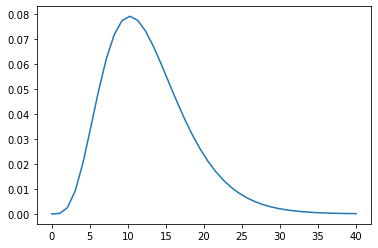

In [36]:
alpha = 5.28
beta = 0.418
x = np.linspace(0, 40, 40)
y = stats.gamma.pdf(x, a=alpha, scale=1/beta)
plt.plot(x, y);

The distribution looks like it represents the ManU forward goals. Let's use these parameters in our informative prior distribution.
$$
\lambda \sim gamma(5.28, 0.418)
$$

### Stan model

Stan implementation of the model is the same as in the pooled model:

In [37]:
print(stan_code)

data {
    int<lower=0> N; // NUMBER OF SEASONS
    int y[N]; // HISTORICAL DATA
    real<lower=0> alpha; // PARAMETER FOR GAMMA DISTRIBUTION
    real<lower=0> beta; // PARAMETER FOR GAMMA DISTRIBUTION
}
parameters {
    real<lower=0> la; // LAMBDA FOR POISSON
}
model {
    target += gamma_lpdf(la | alpha, beta); // PRIOR
    target += poisson_lpmf(y | la); // LIKELIHOOD
}
generated quantities {
    real pred = poisson_rng(la); // PREDICTION FOR CR7

    vector[N] log_lik;
      for (i in 1:N)
        log_lik[i] = poisson_lpmf(y[i] | la);
}


### Implementation

In the models we are going to use 3 different chains with 4000 samples and 4000 warm-up samples, as warm-up of one half of the total samples is a conservative approach that should guarantee that the chains have converged. 

Weakly informative prior:

In [38]:
# STAN MODEL
nest_asyncio.apply()
inputs = {'N': data_cr7.size, 'y': data_cr7, 'alpha': 0.001, 'beta': 0.001}
model = stan.build(program_code=stan_code, data=inputs);
weakly_separate_fit = model.sample(num_chains=3, num_samples=4000, num_warmup=4000, save_warmup=False);
weakly_separate_df = weakly_separate_fit.to_frame()

Building...



Building: found in cache, done.Messages from stanc:
Sampling:   0%
Sampling:  33% (8000/24000)
Sampling:  67% (16000/24000)
Sampling: 100% (24000/24000)
Sampling: 100% (24000/24000), done.
Messages received during sampling:
  Gradient evaluation took 3e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.03 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.03 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.03 seconds.
  Adjust your expectations accordingly!


Informative prior:

In [39]:
# STAN MODEL
nest_asyncio.apply()
inputs = {'N': data_cr7.size, 'y': data_cr7, 'alpha': 5.28, 'beta': 0.418}
model = stan.build(program_code=stan_code, data=inputs);
informative_separate_fit = model.sample(num_chains=3, num_samples=4000, num_warmup=4000, save_warmup=False);
informative_separate_df = informative_separate_fit.to_frame()

Building...



Building: found in cache, done.Messages from stanc:
Sampling:   0%
Sampling:  33% (8000/24000)
Sampling:  67% (16000/24000)
Sampling: 100% (24000/24000)
Sampling: 100% (24000/24000), done.
Messages received during sampling:
  Gradient evaluation took 4e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.04 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.03 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.03 seconds.
  Adjust your expectations accordingly!


### Convergence diagnostics

Before we check our predictions, we should do convergence diagnostics to check if the chains have converged.

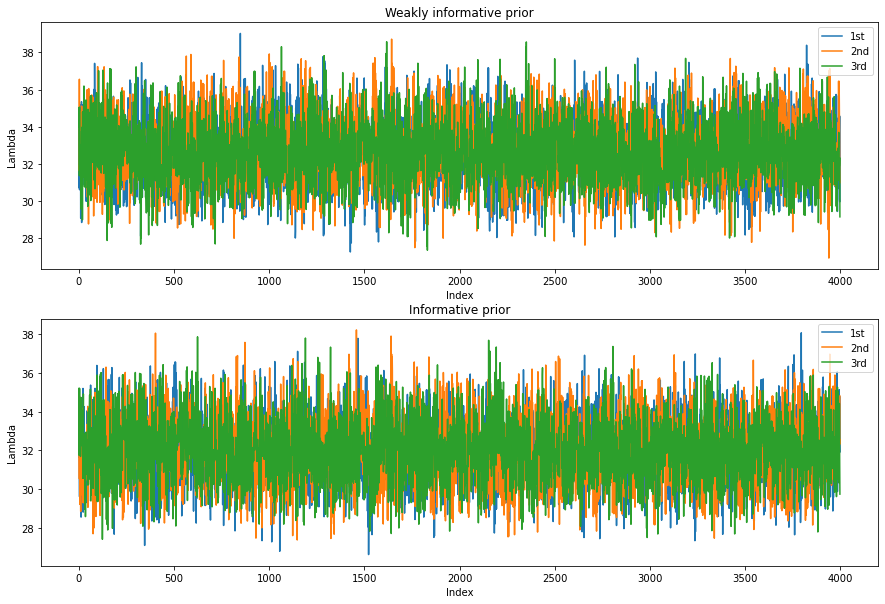

In [40]:
fig, ax = plt.subplots(2, 1)
fig.set_size_inches(15, 10)

ax[0].plot(range(4000), weakly_separate_fit["la"][0][0:4000], label="1st")
ax[0].plot(range(4000), weakly_separate_fit["la"][0][4000:8000], label="2nd")
ax[0].plot(range(4000), weakly_separate_fit["la"][0][8000:12000], label="3rd")
ax[0].legend()
ax[0].set_title("Weakly informative prior")
ax[0].set_xlabel("Index")
ax[0].set_ylabel("Lambda")

ax[1].plot(range(4000), informative_separate_fit["la"][0][0:4000], label="1st")
ax[1].plot(range(4000), informative_separate_fit["la"][0][4000:8000], label="2nd")
ax[1].plot(range(4000), informative_separate_fit["la"][0][8000:12000], label="3rd")
ax[1].legend()
ax[1].set_title("Informative prior")
ax[1].set_xlabel("Index")
ax[1].set_ylabel("Lambda");

The chains seem to mix well and therefore converge. Let's check the R_hat values.

In [41]:
weakly_chains = np.array((weakly_separate_fit["la"][0][0:4000], 
                    weakly_separate_fit["la"][0][4000:8000], weakly_separate_fit["la"][0][8000:12000]))
informative_chains = np.array((informative_separate_fit["la"][0][0:4000], 
                    informative_separate_fit["la"][0][4000:8000], informative_separate_fit["la"][0][8000:12000]))
print(f"Weakly informative chains' R_hat: {az.rhat(weakly_chains)}\nInformative chains' R_hat: {az.rhat(informative_chains)}")

Weakly informative chains' R_hat: 1.0001013713926856
Informative chains' R_hat: 1.0001302806700698


The R_hat values are well below 1.01. The chains have converged.

### Posterior predictive checking

Before checking the results, we should assess first the predictive performance of the models using again the PSIS-LOO-CV. First the weakly informative prior model.

In [42]:
az.loo(weakly_separate_fit, pointwise=True)

Computed from 12000 by 12 log-likelihood matrix

         Estimate       SE
elpd_loo   -45.00     4.12
p_loo        2.07        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       12  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

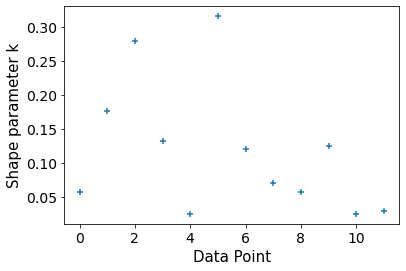

In [43]:
khats = az.loo(weakly_separate_fit, pointwise=True)
az.plot_khat(khats);

The k_hat values are well below 0.5 which means that the PSIS-LOO estimate is reliable. For elpd_loo value we get -45. Then for the informative prior.

In [45]:
az.loo(informative_separate_fit, pointwise=True)

Computed from 12000 by 12 log-likelihood matrix

         Estimate       SE
elpd_loo   -45.04     4.45
p_loo        2.04        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       12  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

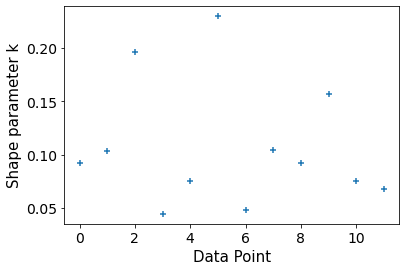

In [46]:
khats = az.loo(informative_separate_fit, pointwise=True)
az.plot_khat(khats);

All the Pareto k_hat values are below 0.5, so the PSIS-LOO estimate is also for this model reliable. For elpd_loo value we get -45 also. 

### Results

After we have checked the predictive performance we would like to see the result of our models. We can first plot the histograms for the predictions.

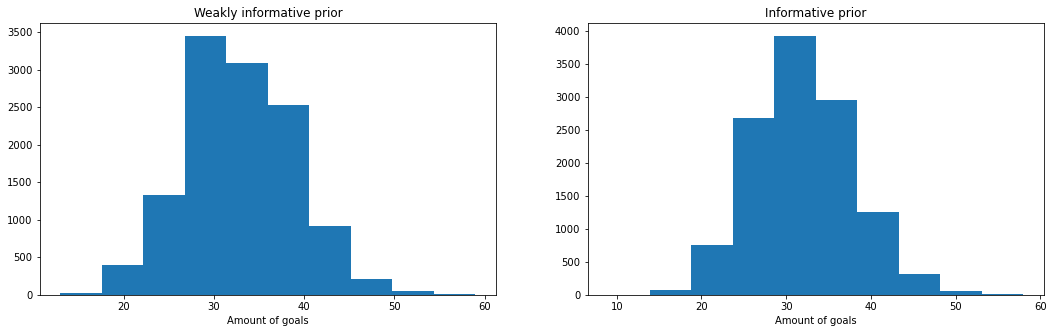

In [47]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(18, 5)

ax[0].hist(weakly_separate_fit["pred"][0])
ax[0].set_title("Weakly informative prior")
ax[0].set_xlabel("Amount of goals")
ax[1].hist(informative_separate_fit["pred"][0])
ax[1].set_title("Informative prior")
ax[1].set_xlabel("Amount of goals");

From the histograms we can see that the informative prior does not seem to affect the predictions that much. Therefore, the separate model is not very sensitive to the added prior information. Let's then get the expected goal amount from both models and the 90% credible interval. Before we calculate these values we should get the Monte Carlo Standard Error so that we know how many decimals to report (we should only report digits for which MCSE is 0.

In [48]:
weakly_mcse = az.mcse(np.array((weakly_separate_fit["la"][0][0:4000], 
                    weakly_separate_fit["la"][0][4000:8000], weakly_separate_fit["la"][0][8000:12000])))
informative_mcse = az.mcse(np.array((informative_separate_fit["la"][0][0:4000], 
                    informative_separate_fit["la"][0][4000:8000], informative_separate_fit["la"][0][8000:12000])))
print(f"For the weakly informative prior model (mean): {weakly_mcse[0]}")
print(f"For the informative prior model (mean): {informative_mcse[0]}")

For the weakly informative prior model (mean): 0.020736108005334628
For the informative prior model (mean): 0.019975120450385634


In [49]:
weakly_mcse_q = az.mcse(np.array((weakly_separate_fit["la"][0][0:4000], 
                    weakly_separate_fit["la"][0][4000:8000], weakly_separate_fit["la"][0][8000:12000])), method="quantile", prob=0.9)
informative_mcse_q = az.mcse(np.array((informative_separate_fit["la"][0][0:4000], 
                    informative_separate_fit["la"][0][4000:8000], informative_separate_fit["la"][0][8000:12000])), method="quantile", prob=0.9)
print(f"For the weakly informative prior model (quantile): {weakly_mcse_q}")
print(f"For the informative prior model (quantile): {informative_mcse_q}")

For the weakly informative prior model (quantile): 0.03967514486584989
For the informative prior model (quantile): 0.02701279212023877


For the model that uses weakly informative prior we have:

In [50]:
m1 = weakly_separate_fit["pred"][0].mean()
ci = (np.percentile(weakly_separate_fit["pred"][0], 5), np.percentile(weakly_separate_fit["pred"][0], 95))
print(f"Expectation for the mean: {m1:.2f}")
print(f"90 % Credible interval: ({ci[0]:.1f}, {ci[1]:.1f})")

Expectation for the mean: 32.73
90 % Credible interval: (23.0, 43.0)


For the model that uses an informative prior we have:

In [52]:
m2 = informative_separate_fit["pred"][0].mean()
cj = (np.percentile(informative_separate_fit["pred"][0], 5), np.percentile(informative_separate_fit["pred"][0], 95))
print(f"Expectation for the mean: {m2:.2f}")
print(f"90 % Credible interval: ({cj[0]:.1f}, {ci[1]:.1f})")

Expectation for the mean: 31.92
90 % Credible interval: (23.0, 43.0)


From the results we can see that there is approximately one goal difference in the expectations and that the credible interval stays the same. Therefore, the model is not very sensitive to prior information and the data affects the results a lot. As both the models have the same elpd_loo values with all Pareto k_hats under 0.5, we will base our model selection decision in the prior choice. As the informative prior uses prior knowledge from the Premier League, we will choose its prediction as our prediction from the separate model.

<b>Basic model prediction: 31.92</b><br>

### Problems in the model

There are some problems in the model. As we saw in previous section, the model's results don't change a lot when we use a weakly informative prior vs. an informative prior. Therefore, the prediction relies quite heavily on the data of Ronaldo's past performance. This could mean that the model does not take enough into account that goal amounts scored in Premier League could differ quite a lot from other leagues. 

## Model 3 - Hierarchical model using new Premier League Forwards

Coming soon...

## Model comparison

Coming soon...